In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recurrent Neural Networks (RNN) with Keras

## Introduction

Recurrent neural networks (RNN) are a class of neural networks that is powerful
for modeling sequence data such as time series or natural language.

Schematically, a RNN layer uses a `for` loop to iterate over the timesteps of a
sequence, while maintaining an internal state that encodes information about the
timesteps it has seen so far.

The Keras RNN API is designed with a focus on:

- **Ease of use**: the built-in `keras.layers.RNN`, `keras.layers.LSTM`,
`keras.layers.GRU` layers enable you to quickly build recurrent models without
having to make difficult configuration choices.

- **Ease of customization**: You can also define your own RNN cell layer (the
inner part of the `for` loop) with custom behavior, and use it with the generic
`keras.layers.RNN` layer (the `for` loop itself). This allows you to quickly
prototype different research ideas in a flexible way with minimal code.


## Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-04-03 00:39:50.357291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-03 00:39:50.357329: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Built-in RNN layers: a simple example

There are three built-in RNN layers in Keras:

1. `keras.layers.SimpleRNN`, a fully-connected RNN where the output from previous
    timestep is to be fed to next timestep.
2. `keras.layers.GRU`, first proposed in
    [Cho et al., 2014](https://arxiv.org/abs/1406.1078).
3. `keras.layers.LSTM`, first proposed in
    [Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).

In early 2015, Keras had the first reusable open-source Python implementations
of LSTM and GRU.

Here is a simple example of a `Sequential` model that processes sequences of
integers, embeds each integer into a 64-dimensional vector, then processes the
sequence of vectors using a `LSTM` layer.

In [3]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

2022-04-03 00:41:03.735099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-03 00:41:03.735148: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-03 00:41:03.735167: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a1661296958a): /proc/driver/nvidia/version does not exist
2022-04-03 00:41:03.749078: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


Built-in RNNs support a number of useful features:

- Recurrent dropout, via the `dropout` and `recurrent_dropout` arguments
- Ability to process an input sequence in reverse, via the `go_backwards`
    argument
- Loop unrolling (which can lead to a large speedup when processing short
    sequences on CPU), via the `unroll` argument
- ...and more.

For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).

## Outputs and states

By default, the output of a RNN layer contains a single vector per sample. This
vector is the RNN cell output corresponding to the last timestep, containing
information about the entire input sequence. The shape of this output is
`(batch_size, units)` where `units` corresponds to the `units` argument passed
to the layer's constructor.

A RNN layer can also return the entire sequence of outputs for each sample (one
vector per timestep per sample), if you set `return_sequences=True`. The shape
of this output is `(batch_size, timesteps, units)`.

In [4]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In addition, a RNN layer can return its final internal state(s). The returned
states can be used to resume the RNN execution later, or
[to initialize another RNN](https://arxiv.org/abs/1409.3215).
This setting is commonly used in the encoder-decoder sequence-to-sequence model,
where the encoder final state is used as the initial state of the decoder.

To configure a RNN layer to return its internal state, set the `return_state`
parameter to `True` when creating the layer. Note that `LSTM` has 2 state 
tensors, but `GRU` only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

In [5]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                
                                                                                              

## RNN layers and RNN cells

In addition to the built-in RNN layers, the RNN API also provides cell-level
APIs. Unlike RNN layers, which processes whole batches of input sequences, the
RNN cell only processes a single timestep.

The cell is the inside of the `for` loop of a RNN layer. Wrapping a cell inside
a `keras.layers.RNN` layer gives you a layer capable of processing batches of
sequences, e.g. `RNN(LSTMCell(10))`.

Mathematically, `RNN(LSTMCell(10))` produces the same result as `LSTM(10)`. In
fact, the implementation of this layer in TF v1.x was just creating the
corresponding RNN cell and wrapping it in a RNN layer.  However using the
built-in `GRU` and `LSTM` layers enable the use of CuDNN and you may see better
performance.

There are three built-in RNN cells, each of them corresponding to the matching
RNN layer.

- `keras.layers.SimpleRNNCell` corresponds to the `SimpleRNN` layer.
- `keras.layers.GRUCell` corresponds to the `GRU` layer.
- `keras.layers.LSTMCell` corresponds to the `LSTM` layer.

The cell abstraction, together with the generic `keras.layers.RNN` class, make it
very easy to implement custom RNN architectures for your research.

## Cross-batch statefulness

When processing very long sequences (possibly infinite), you may want to use the
pattern of **cross-batch statefulness**.

Normally, the internal state of a RNN layer is reset every time it sees a new
batch (i.e. every sample seen by the layer is assumed to be independent of the
past). The layer will only maintain a state while processing a given sample.

If you have very long sequences though, it is useful to break them into shorter
sequences, and to feed these shorter sequences sequentially into a RNN layer
without resetting the layer's state. That way, the layer can retain information
about the entirety of the sequence, even though it's only seeing one
sub-sequence at a time.

You can do this by setting `stateful=True` in the constructor.

If you have a sequence `s = [t0, t1, ... t1546, t1547]`, you would split it into
e.g.

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

Then you would process it via:

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

When you want to clear the state, you  can use `layer.reset_states()`.


> Note: In this setup, sample `i` in a given batch is assumed to be the
continuation of sample `i` in the previous batch. This means that all batches
should contain the same number of samples (batch size). E.g. if a batch contains
`[sequence_A_from_t0_to_t100, sequence_B_from_t0_to_t100]`, the next batch
should contain `[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`.


Here is a complete example:

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


### RNN State Reuse

The recorded states of the RNN layer are not included in the `layer.weights()`.
If you would like to reuse the state from a RNN layer, you can retrieve the
states value by `layer.states` and use it as the initial state for a new layer
via the Keras functional API like
`new_layer(inputs, initial_state=layer.states)`, or model subclassing.

Please also note that sequential model might not be used in this case since it
only supports layers with single input and output, the extra input of initial
state makes it impossible to use here.

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a
RNN model can perform better if it not only processes sequence from start to
end, but also backwards. For example, to predict the next word in a sentence, it
is often useful to have the context around the word, not only just the words
that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

In [8]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           38400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


Under the hood, `Bidirectional` will copy the RNN layer passed in, and flip the
`go_backwards` field of the newly copied layer, so that it will process the
inputs in reverse order.

The output of the `Bidirectional` RNN will be, by default, the concatenation of
the forward layer output and the backward layer output. If you need a different
merging behavior, e.g. concatenation, change the `merge_mode` parameter in the
`Bidirectional` wrapper constructor. For more details about `Bidirectional`,
please check
[the API docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/).

## Performance optimization and CuDNN kernels

In TensorFlow 2.0, the built-in LSTM and GRU layers have been updated to
leverage CuDNN kernels by default when a GPU is available. With this change,
the prior `keras.layers.CuDNNLSTM/CuDNNGRU` layers have been deprecated, and you
can build your model without worrying about the hardware it will run on.

Since the CuDNN kernel is built with certain assumptions, this means the layer
**will not be able to use the CuDNN kernel if you change the defaults of the built-in LSTM or GRU layers**.
E.g.:

- Changing the `activation` function from `tanh` to something else.
- Changing the `recurrent_activation` function from `sigmoid` to something else.
- Using `recurrent_dropout` > 0.
- Setting `unroll` to True, which forces LSTM/GRU to decompose the inner
    `tf.while_loop` into an unrolled `for` loop.
- Setting `use_bias` to False.
- Using masking when the input data is not strictly right padded (if the mask
    corresponds to strictly right padded data, CuDNN can still be used. This is the most
    common case).

For the detailed list of constraints, please see the documentation for the
[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/) and
[GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/) layers.

### Using CuDNN kernels when available

Let's build a simple LSTM model to demonstrate the performance difference.

We'll use as input sequences the sequence of rows of MNIST digits (treating each
row of pixels as a timestep), and we'll predict the digit's label.

In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


Let's load the MNIST dataset:

In [10]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

11501568/11490434 [==============================] - 1s 0us/step


Let's create a model instance and train it.

We choose `sparse_categorical_crossentropy` as the loss function for the model.
The output of the model has shape of `[batch_size, 10]`. The target for the
model is an integer vector, each of the integer is in the range of 0 to 9.

In [11]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 21s 20ms/step - loss: 0.9187 - accuracy: 0.7088 - val_loss: 0.4850 - val_accuracy: 0.8454


Now, let's compare to a model that does not use the CuDNN kernel:

In [12]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 20s 20ms/step - loss: 0.3734 - accuracy: 0.8881 - val_loss: 0.4506 - val_accuracy: 0.8481


When running on a machine with a NVIDIA GPU and CuDNN installed, the model built
with CuDNN is much faster to train compared to the model that uses the regular
TensorFlow kernel.

The same CuDNN-enabled model can also be used to run inference in a CPU-only
environment. The `tf.device` annotation below is just forcing the device
placement. The model will run on CPU by default if no GPU is available.

You simply don't have to worry about the hardware you're running on anymore.
Isn't that pretty cool?

Predicted result is: [3], target result is: 5


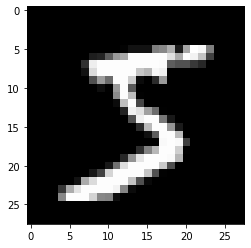

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## RNNs with list/dict inputs, or nested inputs

Nested structures allow implementers to include more information within a single
timestep. For example, a video frame could have audio and video input at the
same time. The data shape in this case could be:

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

In another example, handwriting data could have both coordinates x and y for the
current position of the pen, as well as pressure information. So the data
representation could be:

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

The following code provides an example of how to build a custom RNN cell that
accepts such structured inputs.

### Define a custom cell that supports nested input/output

See
[Making new Layers & Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)
for details on writing your own layers.


In [14]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### Build a RNN model with nested input/output

Let's build a Keras model that uses a `keras.layers.RNN` layer and the custom
cell we just defined.

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### Train the model with randomly generated data

Since there isn't a good candidate dataset for this model, we use random Numpy
data for demonstration.

In [16]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 4s 282ms/step - loss: 0.7599 - rnn_1_loss: 0.2801 - rnn_1_1_loss: 0.4798 - rnn_1_accuracy: 0.0969 - rnn_1_1_accuracy: 0.0330


With the Keras `keras.layers.RNN` layer, You are only expected to define the
math logic for individual step within the sequence, and the `keras.layers.RNN`
layer will handle the sequence iteration for you. It's an incredibly powerful
way to quickly prototype new kinds of RNNs (e.g. a LSTM variant).

For more details, please visit the
[API docs](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/).